# Titanic Competition Solutions

## Datasets Description

* **`PassengerId` :** A unique ID to each Passenger (**1-891**)
* **`Survived` :** A boolean variable (**0** or **1**):
    - **1 = Survived**
    - **0 = Not Survived**
* **`Pclass` :** Ticket Class
    - **1 = 1st**
    - **2 = 2nd**
    - **3 = 3rd class**
* **`Name`:** Passenger Name
* **`Sex` :** Sex of Passenger
* **`Age` :** Age in Years
* **`SibSp` :** Number of Siblings / Spouses Aboard
    - **Sibling = brother, sister, stepbrother, stepsister**
    - **Spouse = husband, wife (mistresses and fiancés were ignored)**
* **`Parch` :** Number of parents / children aboard the titanic
    - **Parent = mother, father**
    - **Child = daughter, son, stepdaughter, stepson**
* **`Ticket` :** Ticket number
* **`Fare` :** Passenger Fare
* **`Cabin` :** Cabin number
* **`Embarked` :** Port of Embarkation
    - **C = Cherbourg**
    - **Q = Queenstown**
    - **S = Southampton**

**Which features are categorical?**
- **Categorical :** Survived, Sex and Embarked
- **Ordinal:** Pclass

**Which features are numerical?**
- **Continous:** Age, Fare
- **Discrete:** SibSp, Parch

In [1]:
%%HTML

<b> Amazing work; Titanic - Great loss of life by Simon Rowe <b>
<div class='tableauPlaceholder' id='viz1516349898238' style='position: relative'><noscript><a href='#'><img alt='Titanic Training Dataset ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ti&#47;Titanic_data_mining&#47;Dashboard1&#47;1_rss.png' width="200" height="300" style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Titanic-Greatlossoflife&#47;MainDashboard' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;app&#47;profile&#47;simon.rowe&#47;viz&#47;Titanic-Greatlossoflife&#47;MainDashboard&#47;1.png'  /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1516349898238');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
import io
import os
import warnings
import re
from pandas.api.types import CategoricalDtype
import missingno as msno

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

import warnings
warnings.filterwarnings('ignore')

orange_black = ['#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820']

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#Helper function
def eksik_deger_tablosu(df):
    eksik_deger = df.isnull().sum()
    eksik_deger_yüzde = 100*df.isnull().sum()/len(df)
    eksik_deger_tablo = pd.concat([eksik_deger,eksik_deger_yüzde], axis=1)
    eksik_deger_tablo_son = eksik_deger_tablo.rename(columns = {0: "Eksik Gözlem",
                                                                1: "% Değeri"})
    return eksik_deger_tablo_son
#########################################################################################
def eksik_deger_yuzde(df):
    total_cells = np.product(df.shape)
    missing_values_count = df.isnull().sum()
    total_missing = missing_values_count.sum()
    print("% of missing where data:", (total_missing/total_cells) * 100)
#########################################################################################
def age_buckets(x):
    if x<10:
        return "0-9"
    elif x<20:
        return '10-19'
    elif x < 30:
        return '20-29' 
    elif x < 40: 
        return '30-39' 
    elif x < 50: 
        return '40-49' 
    elif x < 60: 
        return '50-59' 
    elif x < 70: 
        return '60-69' 
    elif x >=70: 
        return '70+' 
    else: 
        return 'other'
######################################################################################### 
def sex_agegroup(df):
    sex_agegroup_summary = df.groupby(['Sex','Age_Group'], as_index=False)['Survived'].mean()
    return sex_agegroup_summary
######################################################################################### 
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)
#########################################################################################
def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)
#########################################################################################
def title_name (df):
    for i in df:
        df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
        return pd.crosstab(df['Title'], df['Sex'])
#########################################################################################
def bar_chart(feature):
    survived = train_data[train_data['Survived']==1][feature].value_counts()
    died = train_data[train_data['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,died])
    df.index = ['Survived','Died']
    df.plot(kind='bar',stacked=True, figsize=(10,5))
#########################################################################################
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)
#########################################################################################
def recover_train_test_target():
    global combined
    
    targets = pd.read_csv('../input/titanic/train.csv', usecols=['Survived'])['Survived'].values
    train = combined.iloc[:891]
    test = combined.iloc[891:]
    
    return train, test, targets

* Training set has **891** rows and test set has **418** rows
* Training set has **12** features and test set has **11** features

In [4]:
train_data = pd.read_csv("../input/titanic/train.csv")
test_data = pd.read_csv("../input/titanic/test.csv")
train_data['Age_Group'] = train_data.Age.apply(age_buckets)
test_data['Age_Group'] = test_data.Age.apply(age_buckets)

df_all = concat_df(train_data, test_data)

title_name(df_all)

df_all['Title'] = df_all['Title'].replace('Mlle', 'Miss')
df_all['Title'] = df_all['Title'].replace('Ms', 'Miss')
df_all['Title'] = df_all['Title'].replace('Mme', 'Mrs')

df_all['Title'] = df_all['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')

df_num = train_data[['Age','SibSp','Parch','Fare']]
df_cat = train_data[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

print("Training Shape = ",train_data.shape)
print("Testing Shape = ",test_data.shape)
print("All Data Shape = ",df_all.shape)
print("Train Data Columns Name = ", train_data.columns )
print("Test Data Columns Name = ", test_data.columns )

Training Shape =  (891, 13)
Testing Shape =  (418, 12)
All Data Shape =  (1309, 14)
Train Data Columns Name =  Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_Group'],
      dtype='object')
Test Data Columns Name =  Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_Group'],
      dtype='object')


In [5]:
train_data.info()
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Age_Group    891 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,20-29
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30-39
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,20-29
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30-39
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30-39


In [6]:
test_data.info()
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  Age_Group    418 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 39.3+ KB


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Group
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,30-39
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,40-49
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,60-69
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,20-29
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,20-29


In [7]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [8]:
train_data.describe(include=['O']).T

,count,unique,top,freq
Name,891,891,"Braund, Mr. Owen Harris",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644
Age_Group,891,9,20-29,220


**Histogram plots of numerical variables.** 

It can be said that the age variable shows a more normal distribution.

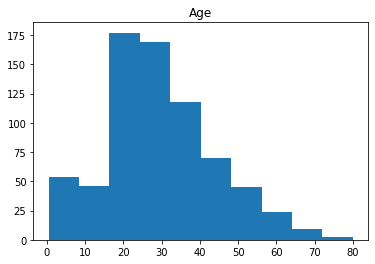

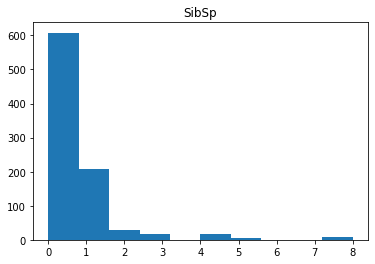

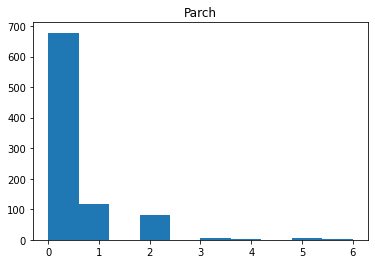

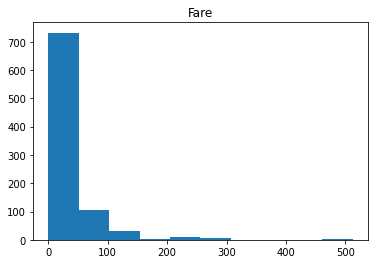

In [9]:
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

**Histogram plots of categorical variables.**

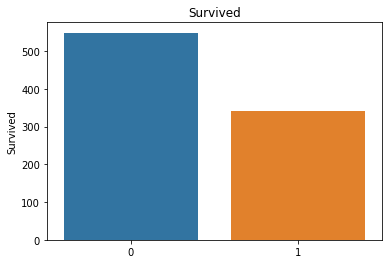

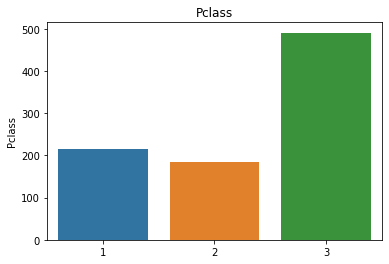

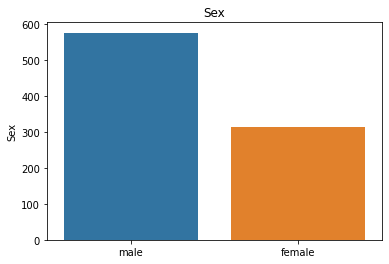

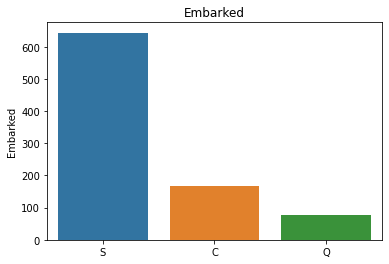

In [10]:
df_cat2 = train_data[['Survived','Pclass','Sex','Embarked']]
for i in df_cat2.columns:
    sns.barplot(df_cat2[i].value_counts().index,df_cat2[i].value_counts()).set_title(i)
    plt.show()

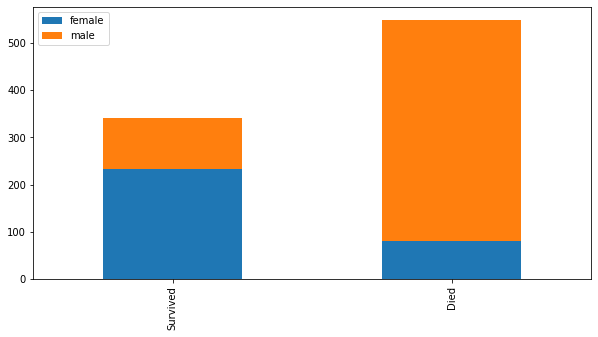

In [11]:
bar_chart("Sex")

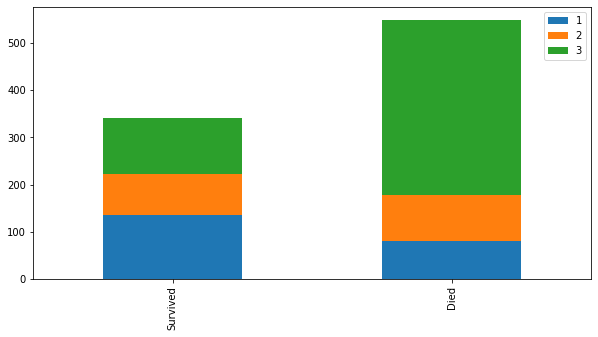

In [12]:
bar_chart("Pclass")

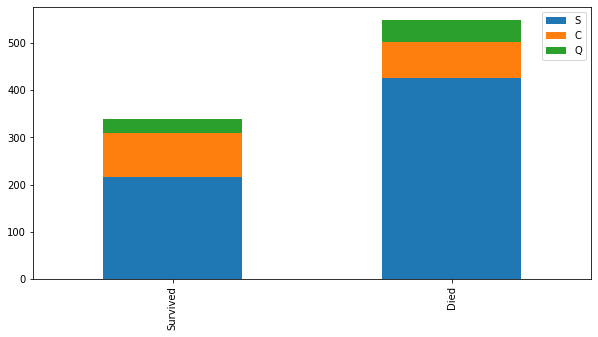

In [13]:
bar_chart('Embarked')

There is a positive relationship between SibSp and Parch variables.

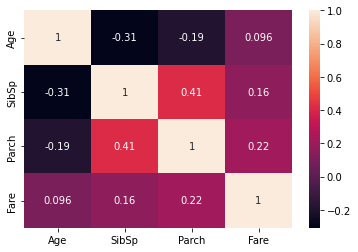

In [14]:
sns.heatmap(df_num.corr(), annot = True);

**Of the survivors:**

* average age 28, 
* average fare 48.395408

In [15]:
pd.pivot_table(train_data, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


* There are missing values on Age, Cabin and Embarked in the train data.
* There are missing values on Age, Cabin and Fare in the test data.

% of missing where data: 7.47647414314081


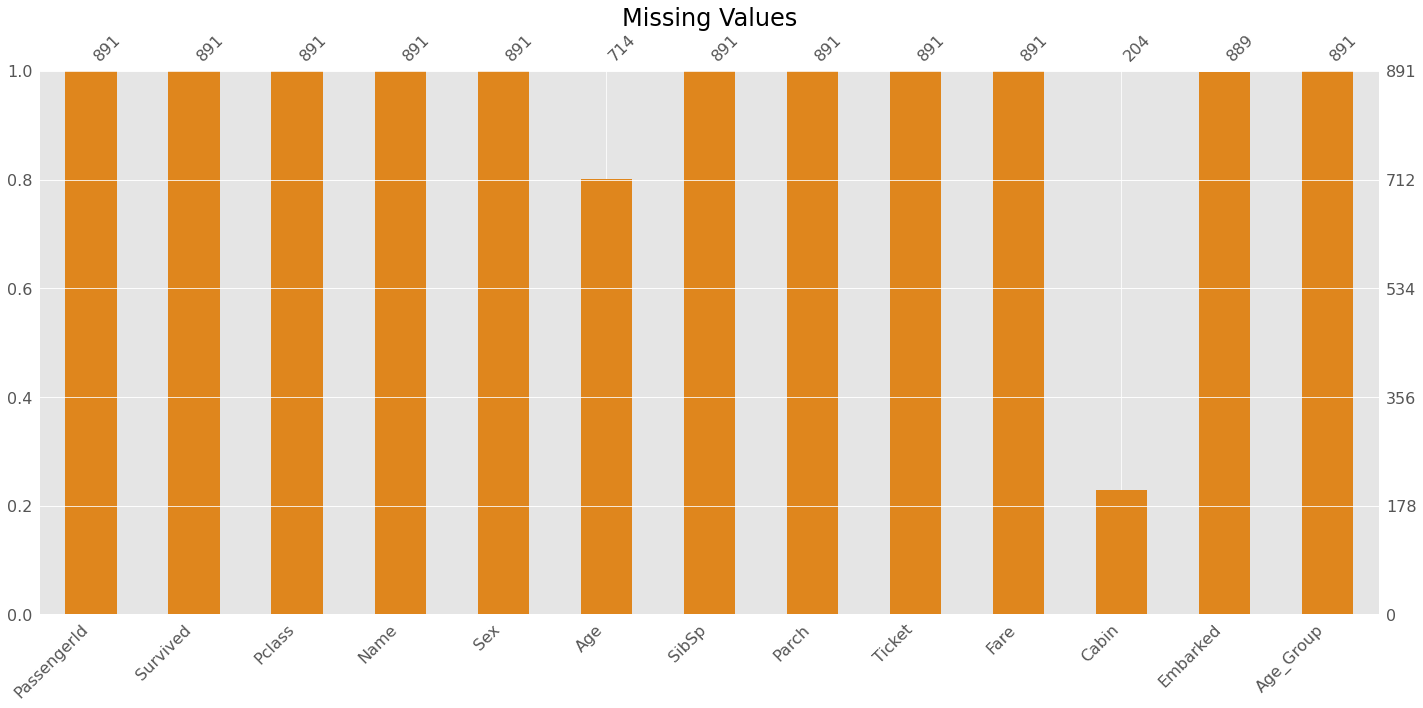

In [16]:
eksik_deger_yuzde(train_data)

plt.style.use('ggplot')

msno.bar(train_data, color=(orange_black[1]))

plt.title('Missing Values', fontsize=24)

plt.show()

% of missing where data: 8.253588516746412


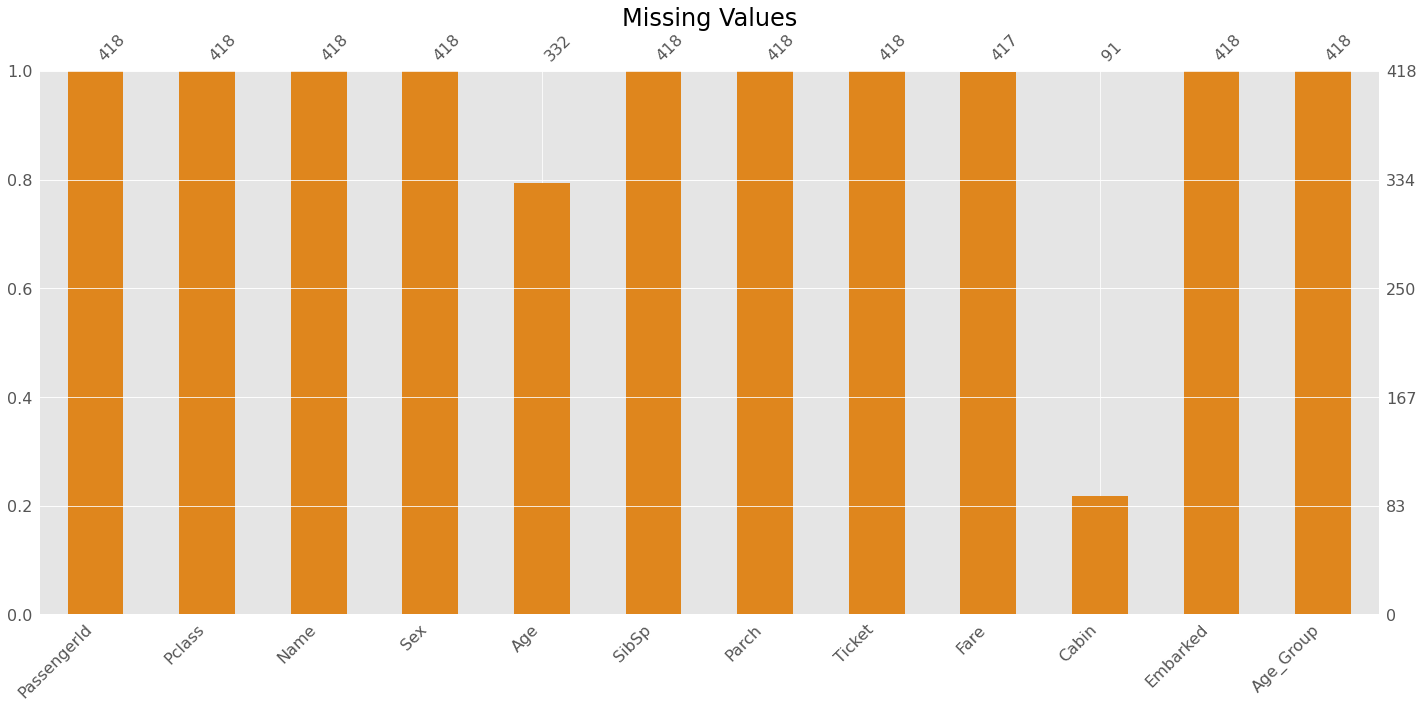

In [17]:
eksik_deger_yuzde(test_data)

msno.bar(test_data, color=(orange_black[1]))

plt.title('Missing Values', fontsize=24)

plt.show()

In [18]:
df_all["Age"].fillna(df_all.groupby(['Sex','Pclass'])["Age"].transform("median"), inplace=True)
df_all["Embarked"].fillna("S", inplace = True)
df_all["Fare"].fillna(df_all.groupby(['Pclass'])["Fare"].transform("median"), inplace=True)

### Did passenger class made any difference to his survival?
* Of the 1st class passengers 136 survived and 80 died
* Of the 2nd class passengers 87 survived and 97 died
* Of the 3rd class passengers 119 survived and 372 died
* If attention is paid, death is higher in 3rd class passengers. This is because, sank from the bow of the ship where third class rooms located conclusion.

In [19]:
crosstab = pd.crosstab(train_data.Survived, train_data.Pclass, margins=True, margins_name="Total")

crosstab.index = ["Died" , "Survived" , "Row_Total"] 
crosstab.columns= ["1st","2nd","3rd", "Col_Total"]
crosstab

,1st,2nd,3rd,Col_Total
Died,80,97,372,549
Survived,136,87,119,342
Row_Total,216,184,491,891


### Which gender had more survival?
* While approximately 74% of the female passengers survived, approximately 18% of the male passengers survived. 
* Being a woman here has been more liberating.

In [20]:
group_by_sex = train_data.groupby('Sex')

survived_by_sex = group_by_sex['Survived'].sum()
survived_by_sex.name = 'Survived'

total_by_sex = group_by_sex['Survived'].size()
total_by_sex.name = 'Total'

survived_total_by_sex = pd.concat([survived_by_sex, total_by_sex], axis=1)

percent_survived = (survived_total_by_sex['Survived'] / survived_total_by_sex['Total']) * 100
survived_total_by_sex['Percentage'] = percent_survived

survived_total_by_sex

,Survived,Total,Percentage
Sex,,,
female,233,314,74.203822
male,109,577,18.890815


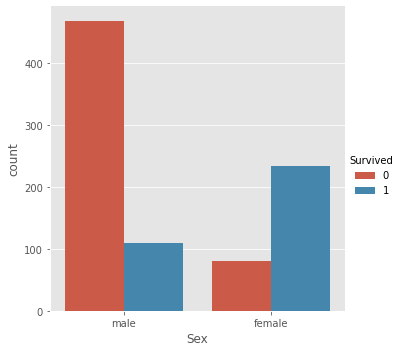

In [21]:
sns.catplot(x ="Sex", hue ="Survived",
kind ="count", data = train_data);

### Person travelling with others had more survival possibility?
* Passengers who do not travel alone are on average 26 years old.
* Passengers who do not travel alone have an average of 2nd class tickets.
* Passengers who do not travel alone have an average of 48.83 fare.



* Passengers who travel alone are on average 31 years old.
* Passengers who travel alone have an average of 2nd class tickets.
* Passengers who travel alone have an average of 21.24 fare.


In [22]:
for i in train_data:
    is_not_alone = (train_data.SibSp + train_data.Parch) >= 1
    passengers_not_alone = train_data[is_not_alone]
print('Not alone - describe',display(passengers_not_alone.describe()))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,354.000000,354.000000,354.000000,310.000000,354.000000,354.000000,354.000000
mean,427.796610,0.505650,2.169492,26.413452,1.316384,0.960452,48.832275
std,259.122836,0.500676,0.864520,15.834923,1.420774,1.039512,55.307615
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,6.495800
25%,195.000000,0.000000,1.000000,16.000000,1.000000,0.000000,18.000000
50%,419.000000,1.000000,2.000000,26.000000,1.000000,1.000000,27.750000
75%,645.750000,1.000000,3.000000,37.000000,1.000000,2.000000,59.044800
max,889.000000,1.000000,3.000000,70.000000,8.000000,6.000000,512.329200


Not alone - describe None


In [23]:
for i in train_data:
    is_alone = (train_data.SibSp + train_data.Parch) == 0
    passengers_alone = train_data[is_alone]
print('Alone - describe',display(passengers_alone.describe()))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,537.000000,537.000000,537.000000,404.000000,537.0,537.0,537.000000
mean,458.000000,0.303538,2.400372,32.220297,0.0,0.0,21.242689
std,255.714174,0.460214,0.804511,12.899871,0.0,0.0,42.223510
min,3.000000,0.000000,1.000000,5.000000,0.0,0.0,0.000000
25%,235.000000,0.000000,2.000000,22.000000,0.0,0.0,7.775000
50%,466.000000,0.000000,3.000000,29.500000,0.0,0.0,8.137500
75%,681.000000,1.000000,3.000000,39.000000,0.0,0.0,15.000000
max,891.000000,1.000000,3.000000,80.000000,0.0,0.0,512.329200


Alone - describe None


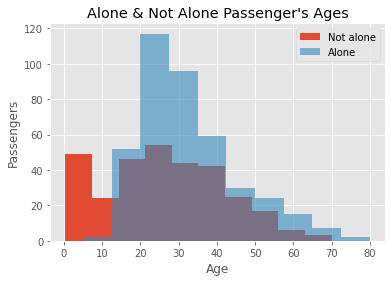

In [24]:
passengers_not_alone.Age.hist(label='Not alone')
passengers_alone.Age.hist(label='Alone', alpha=0.6)

plt.xlabel('Age')
plt.ylabel('Passengers')
plt.legend(loc='best')
plt.title('Alone & Not Alone Passenger\'s Ages');

* About 30% of the alone passengers survived, while about 50% of the non-alone passengers survived.
* About 70% of the alone passengers survived, while about 50% of the non-alone passengers survived.

In [25]:
notalone = np.where((train_data.SibSp + train_data.Parch) >= 1, 'Not Alone', 'Alone')
loneliness_summary = train_data.groupby(notalone, as_index=False)['Survived'].agg([np.sum, np.size])
loneliness_summary = loneliness_summary.rename(columns={'sum':'Survived', 'size':'Total'})
loneliness_summary['Percent survived'] = (loneliness_summary.Survived / loneliness_summary.Total) * 100
loneliness_summary

,Survived,Total,Percent survived
Alone,163,537,30.353818
Not Alone,179,354,50.564972


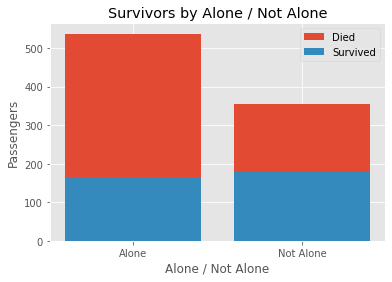

In [26]:
x = range(len(loneliness_summary.index.values))
ht = loneliness_summary.Total
hs = loneliness_summary.Survived

pht = plt.bar(x, ht)
phs = plt.bar(x, hs)

plt.xticks(x, loneliness_summary.index.values)
plt.xlabel('Alone / Not Alone')
plt.ylabel('Passengers')
plt.title('Survivors by Alone / Not Alone')

plt.legend([pht,phs],['Died', 'Survived']);

### Which age group had a better chance of survival?
* 30-39 age group passengers had better chance of survival.
* 20-29 age group passengers had unlucky of survival.

In [27]:
age_group_summary = train_data.groupby(['Age_Group'], as_index=False)['Survived'].agg([np.sum, np.size])
age_group_summary = age_group_summary.rename(columns={'sum':'Survived', 'size':'Total'})
age_group_summary['SurvivedPercent'] = (age_group_summary.Survived / age_group_summary.Total) * 100
age_group_summary['DiedPercent'] = ((age_group_summary.Total - age_group_summary.Survived) / age_group_summary.Total) * 100
age_group_summary

,Survived,Total,SurvivedPercent,DiedPercent
Age_Group,,,,
0-9,38,62,61.290323,38.709677
10-19,41,102,40.196078,59.803922
20-29,77,220,35.000000,65.000000
30-39,73,167,43.712575,56.287425
40-49,34,89,38.202247,61.797753
50-59,20,48,41.666667,58.333333
60-69,6,19,31.578947,68.421053
70+,1,7,14.285714,85.714286
other,52,177,29.378531,70.621469


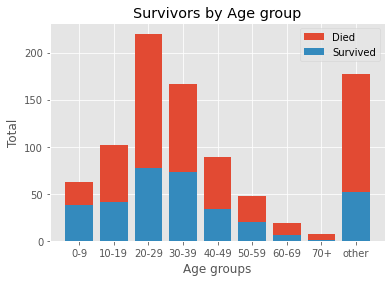

In [28]:
x = range(len(age_group_summary.index.values))
ht = age_group_summary.Total
hs = age_group_summary.Survived

pht = plt.bar(x, ht)
phs = plt.bar(x, hs)

plt.xticks(x, age_group_summary.index.values)
plt.xlabel('Age groups')
plt.ylabel('Total')
plt.title('Survivors by Age group')

plt.legend([pht,phs],['Died', 'Survived']);

**Pclass and Survived**

There is a relationship between survivors and pclass = 3.

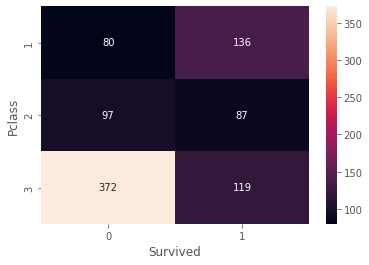

In [29]:
# Group the dataset by Pclass and Survived and then unstack them
group = train_data.groupby(['Pclass', 'Survived'])
pclass_survived = group.size().unstack()
 
# Heatmap - Color encoded 2D representation of data.
sns.heatmap(pclass_survived, annot = True, fmt ="d");

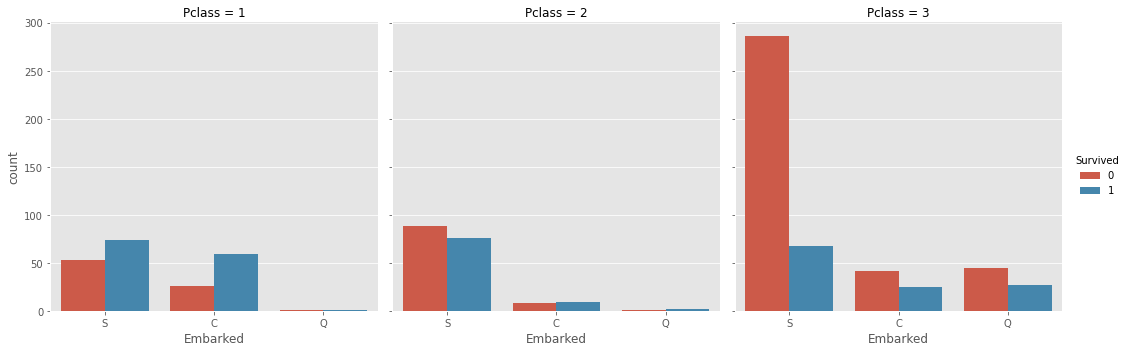

In [30]:
sns.catplot(x ='Embarked', hue ='Survived',
kind ='count', col ='Pclass', data = train_data);


**In progress**

Thank you for reading. If you like, please upvote notebook :)

**References**

This notebook is created by learning from the following:

**[1.]** https://notebook.community/vikramsjn/Investigate-Titanic-Dataset/Analysis%20of%20Titanic%20Dataset

**[2.]** https://github.com/ahmedbesbes/How-to-score-0.8134-in-Titanic-Kaggle-Challenge/blob/master/article_1.ipynb

**[3.]** https://github.com/minsuk-heo/kaggle-titanic/blob/master/titanic-solution.ipynb

**[4.]** https://github.com/agconti/kaggle-titanic/blob/master/Titanic.ipynb

**[5.]** https://www.geeksforgeeks.org/python-titanic-data-eda-using-seaborn/

**[6.]** https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial

**[7.]** https://www.kaggle.com/startupsci/titanic-data-science-solutions
